In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
from matplotlib.pyplot import figure
from importlib import reload
import sys
import src.SABR.sabr
import src.SABR.sabr_approx
reload(src.SABR.sabr)
reload(src.SABR.sabr_approx)
from sklearn.linear_model import LinearRegression

# from src.SABR.sabr import calibrate_sabr
from src.SABR.sabr_approx import calibrate_sabr
from src.utils import process_data, round_params
import datetime
import warnings
warnings.filterwarnings("ignore")
import h5py
import matplotlib.dates as mdates
from tqdm.notebook import tqdm

CPU times: user 22.5 s, sys: 4.87 s, total: 27.4 s
Wall time: 37.6 s


<AxesSubplot: >

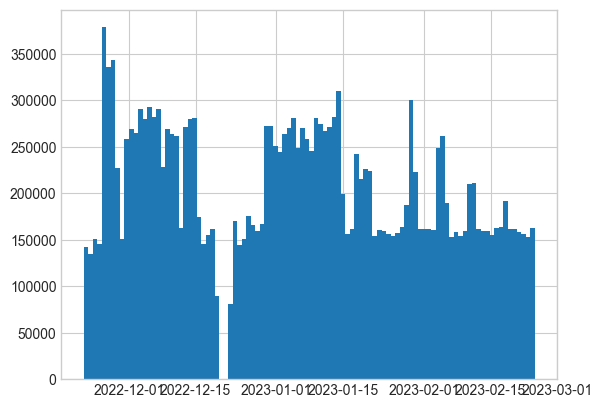

In [3]:
%%time
# heavy
raw = pd.HDFStore('datasets/eth-20230224.h5','r').get("/eth")
# raw2 = pd.HDFStore('../datasets/eth-20230127.h5','r').get("/eth")
# raw3 = pd.HDFStore('../datasets/eth-20230310.h5','r').get("/eth")
# raw = pd.concat([raw1, raw2, raw3]).drop_duplicates()
raw.dt.hist(bins = 100)

In [4]:
%%time
df = process_data(raw)
df.head()

CPU times: user 51.1 s, sys: 25.7 s, total: 1min 16s
Wall time: 2min 10s


,dt,mark_price,instrument,type,strike_price,expiration,underlying_price,timestamp
0,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-1700-C,call,1700,1669334400000000,1133.9,1669036104511000
1,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-2400-C,call,2400,1669334400000000,1133.9,1669036104511000
2,2022-11-21 13:08:24.511,0.0020,ETH-25NOV22-700-P,put,700,1669334400000000,1133.9,1669036104511000
3,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-3800-C,call,3800,1669334400000000,1133.9,1669036104511000
4,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-3400-C,call,3400,1669334400000000,1133.9,1669036104511000


# Params dynamics

In [66]:
%%time
number_of_dots = 150
timestamps_hm = []

params_all = []
params_beta = []

errors_all = []
errors_beta = []

alpha = np.float64(1.0)
v = np.float64(1.3)
beta = np.float64(0.9)  
rho = np.float64(-0.1) 

start_params = np.array([alpha, v, beta, rho])

# Get ticks with similar distnce from available data
calibr_borders = df[(df["dt"] >= "2023-02-04") & (df["dt"] <= "2023-02-04 23:00:00")].copy()
df_only_exp = calibr_borders[calibr_borders["expiration"] == calibr_borders.sample(1).expiration.iloc[0]].copy()

print("Optimize first params with random start once")
calibrated_params_all, first_error_all, _ = calibrate_sabr(df = df_only_exp, 
                                                        start_params = start_params, 
                                                        calibration_type = "all")
calibrated_params_beta, first_error_beta, _ = calibrate_sabr(df = df_only_exp, 
                                                        start_params = start_params, 
                                                        calibration_type = "beta", beta = 1.0)


print("All first calibrated:", round_params(calibrated_params_all), "error:", first_error_all)
print("Beta first calibrated:", round_params(calibrated_params_beta), "error:", first_error_beta)


timestamps = np.linspace(calibr_borders.timestamp.min(), calibr_borders.timestamp.max(), number_of_dots)
for timestamp in tqdm(timestamps):
    # zero params for each point are params from last step
    calibrated_params_all, error_all, _ = calibrate_sabr(df = df_only_exp, start_params = calibrated_params_all, 
                                timestamp = timestamp, calibration_type = "all")
#         print("All calibrated:", round_params(calibrated_params_all), "error:", error_all)

    calibrated_params_beta, error_beta, _ = calibrate_sabr(df = df_only_exp, start_params = calibrated_params_beta, 
                                timestamp = timestamp, calibration_type = "beta", beta = 1.0)
#         print("nu0 calibrated:", round_params(calibrated_params_beta), "error:", error_beta)

    params_all.append(calibrated_params_all)
    errors_all.append(error_all)
    params_beta.append(calibrated_params_beta)
    errors_beta.append(error_beta)
    timestamps_hm.append(timestamp)
        
#         print("    ")

timestamps_hm = [datetime.datetime.fromtimestamp(x/1000000.0) for x in timestamps_hm]
params_all = np.array(params_all).T
params_beta = np.array(params_beta).T





Optimize first params with random start once
All first calibrated: [1.108, 4.693, 0.912, -0.099] error: 0.01069441204138896
Beta first calibrated: [0.591, 4.569, 1.0, -0.132] error: 0.010729646330994444


  0%|          | 0/150 [00:00<?, ?it/s]

CPU times: user 14.3 s, sys: 132 ms, total: 14.5 s
Wall time: 14.5 s


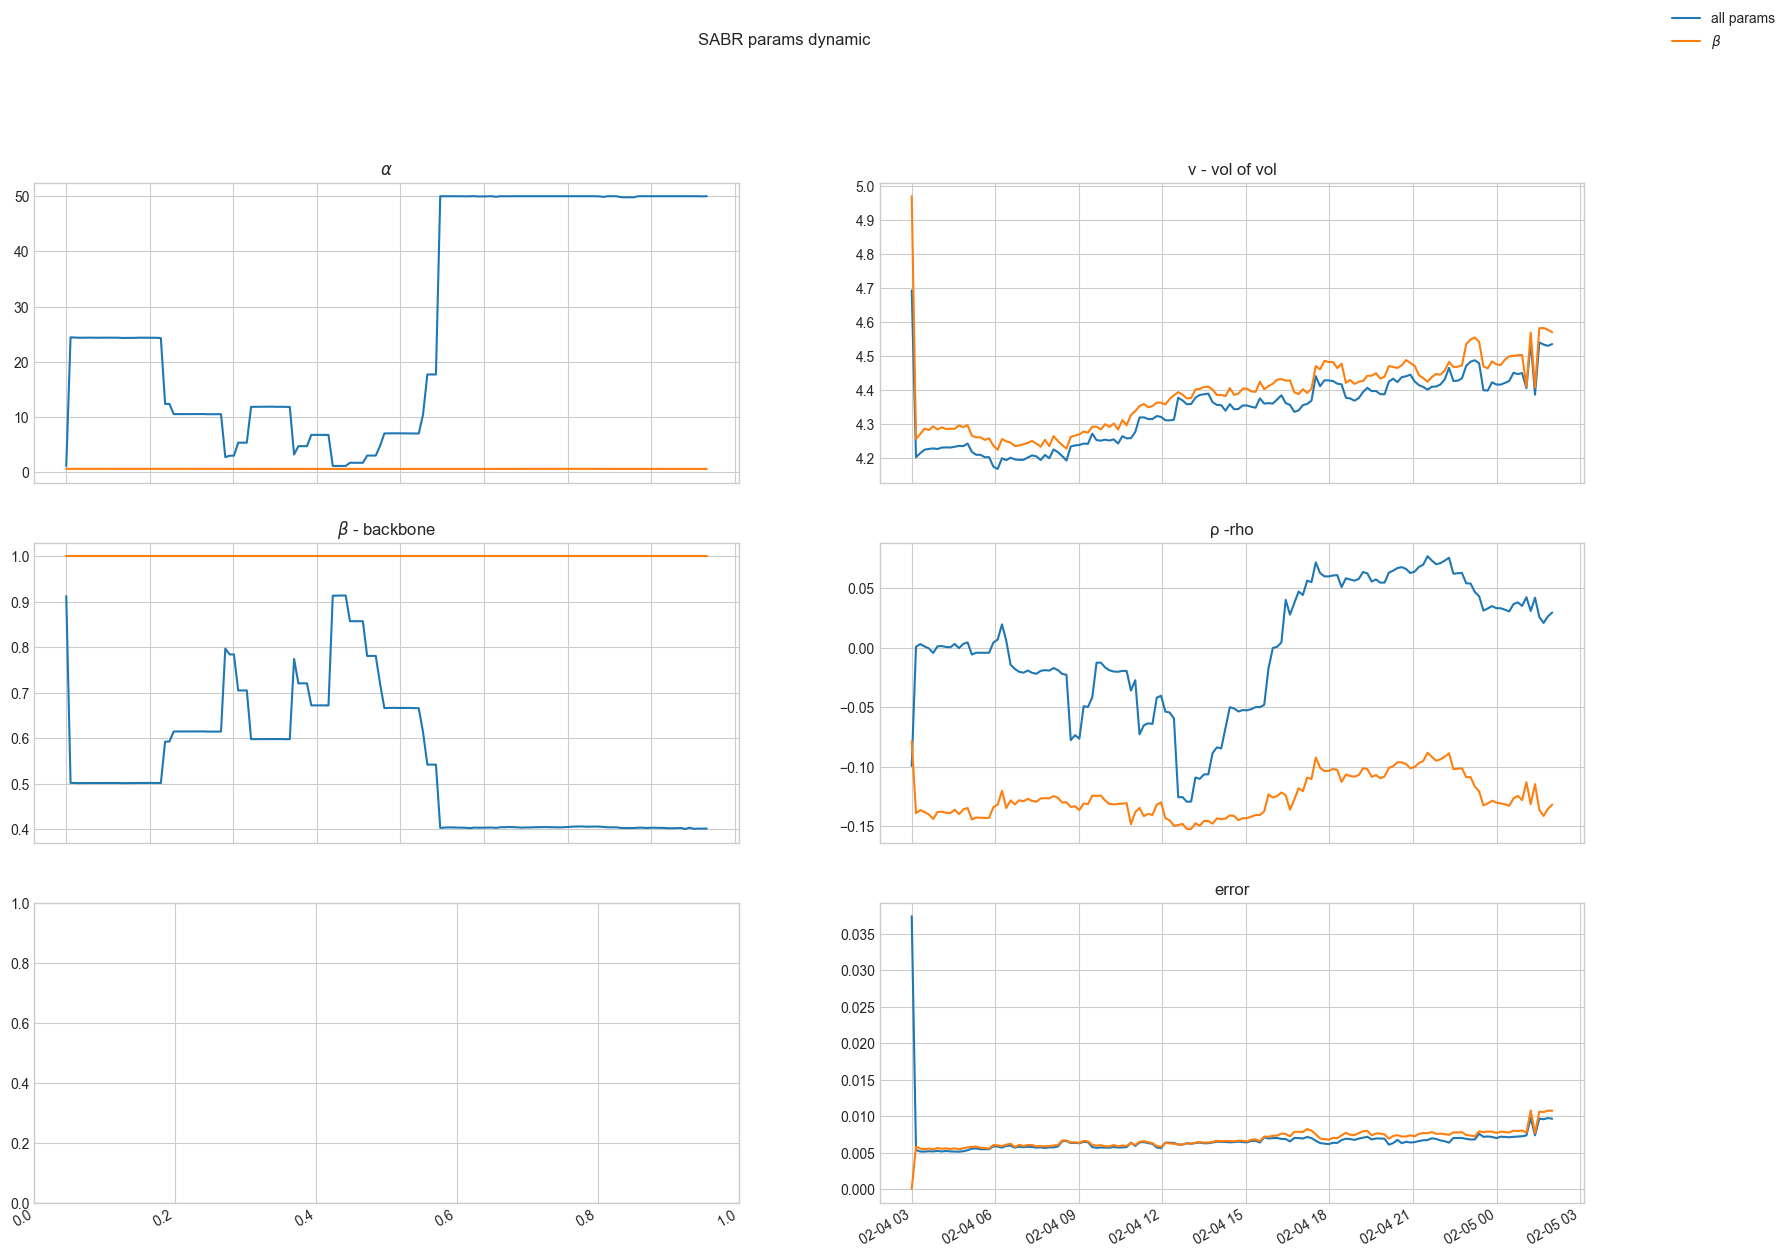

In [68]:
fig, axs =  plt.subplots(nrows=3, ncols=2, figsize=(20, 15))

axs[0, 0].plot(timestamps_hm, params_all[0], label = "all params")
axs[0, 1].plot(timestamps_hm, params_all[1])
axs[1, 0].plot(timestamps_hm, params_all[2])
axs[1, 1].plot(timestamps_hm, params_all[3])
axs[2, 1].plot(timestamps_hm, errors_all)

axs[0, 0].plot(timestamps_hm, params_beta[0], label = r"$\beta$")
axs[0, 1].plot(timestamps_hm, params_beta[1])
axs[1, 0].plot(timestamps_hm, params_beta[2])
axs[1, 1].plot(timestamps_hm, params_beta[3])
axs[2, 1].plot(timestamps_hm, errors_beta)


axs[0, 0].set_title(r"$\alpha$")
axs[0, 1].set_title(r"v - vol of vol")
axs[1, 0].set_title(r"$\beta$ - backbone")
axs[1, 1].set_title("ρ -rho")
axs[2, 1].set_title("error")

plt.figlegend() 
fig.suptitle("SABR params dynamic")
plt.gcf().autofmt_xdate()
plt.show()

# Volatility smile

In [77]:
df_only_exp = df[df["expiration"] == df.sample(1).expiration.iloc[0]].copy()
needed_stamp = df_only_exp.sample(1).iloc[0].timestamp
print(needed_stamp)

1670218148961000


In [80]:
alpha = np.float64(1.0) 
v = np.float64(1.3) 
beta = np.float64(0.9) 
rho = np.float64(-0.1) 

start_params = np.array([alpha, v, beta, rho])

pars_all, err_all, C_all = calibrate_sabr(df = df_only_exp, 
                                          start_params = start_params, 
                                          timestamp = needed_stamp,
                                          calibration_type= "all")

pars_beta, err_beta, C_beta = calibrate_sabr(df = df_only_exp, 
                                          start_params = start_params, 
                                          timestamp = needed_stamp,
                                          calibration_type= "beta", beta = 1.0)

print("All:")
print(round_params(pars_all))
print(err_all)
print("   ")

print("Beta:")
print(round_params(pars_beta))
print(err_beta)


All:
[1.185, 4.96, 0.925, -0.2]
0.00683618116787134
   
Beta:
[0.687, 5.052, 1.0, -0.213]
0.0066060120400242665


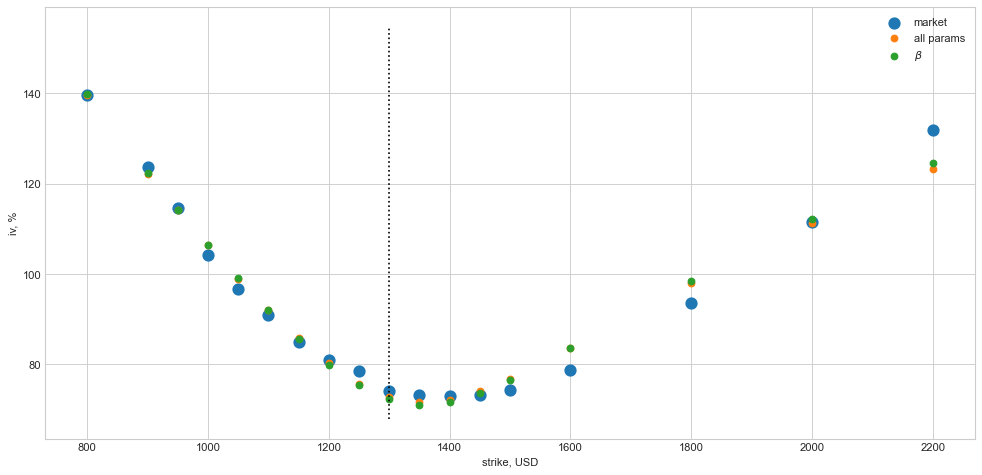

In [81]:
figure(figsize=(15, 7), dpi=80)

plt.scatter(C_all["strike_price"], C_all["iv"], label = "market", linewidths = 5)

# bid,ask iv
# plt.plot(C_sing_exp_all["strike_price"], C_sing_exp_all["ask_iv"], '--', label = "ask_iv", color = "black")
# plt.plot(C_sing_exp_all["strike_price"], C_sing_exp_all["bid_iv"], '--', label = "bid_iv", color = "yellow")

plt.scatter(C_all["strike_price"], C_all["calibrated_iv"], label = "all params")
plt.scatter(C_beta["strike_price"], C_beta["calibrated_iv"], label = r"$\beta$")


plt.vlines([C_all.underlying_price.mean()], C_all.iv.min() - 5, 
           C_all.iv.max() + 15, color = "black", linestyles = "dotted")

plt.xlabel("strike, USD")
plt.ylabel("iv, %")
plt.legend()
plt.show()

# Dependency params of expiration

In [109]:
df.timestamp.sample(1)

4310744    1673809388110000
Name: timestamp, dtype: int64

In [110]:
needed_stamp = 1673809388110000
alpha = np.float64(1.0) 
v = np.float64(1.3) 
beta = np.float64(0.9) 
rho = np.float64(-0.1) 
start_params = np.array([alpha, v, beta, rho])
expirations_list_days = []

params_all_exp, params_beta_exp = [], []

for expiration in tqdm(df.expiration.unique()):
    try:
        single_expiration = df[df["expiration"] == expiration].copy()
        pars_all, err_all, C_all = calibrate_sabr(df = single_expiration, 
                                                  start_params = start_params, 
                                                  timestamp = needed_stamp,
                                                  calibration_type= "all")

        pars_beta, err_beta, C_beta = calibrate_sabr(df = single_expiration, 
                                                  start_params = start_params, 
                                                  timestamp = needed_stamp,
                                                  calibration_type= "beta", beta = 1.0)
        expirations_list_days.append(int((expiration - needed_stamp)/ 1e6/ 3600/ 24))
        
    except:
        print(f"No expiration {expiration} per timestamp: {needed_stamp}")
        continue
    
    params_all_exp.append(pars_all)
    params_beta_exp.append(pars_beta)

params_all_exp = np.array(params_all_exp).T
params_beta_exp = np.array(params_beta_exp).T


  0%|          | 0/15 [00:00<?, ?it/s]

No expiration 1669334400000000 per timestamp: 1673809388110000
No expiration 1671148800000000 per timestamp: 1673809388110000
No expiration 1670544000000000 per timestamp: 1673809388110000
No expiration 1669939200000000 per timestamp: 1673809388110000
No expiration 1671753600000000 per timestamp: 1673809388110000
No expiration 1672358400000000 per timestamp: 1673809388110000
No expiration 1672963200000000 per timestamp: 1673809388110000
No expiration 1673568000000000 per timestamp: 1673809388110000
No expiration 1675382400000000 per timestamp: 1673809388110000
No expiration 1675987200000000 per timestamp: 1673809388110000
No expiration 1676592000000000 per timestamp: 1673809388110000
No expiration 1677196800000000 per timestamp: 1673809388110000
No expiration 1677801600000000 per timestamp: 1673809388110000


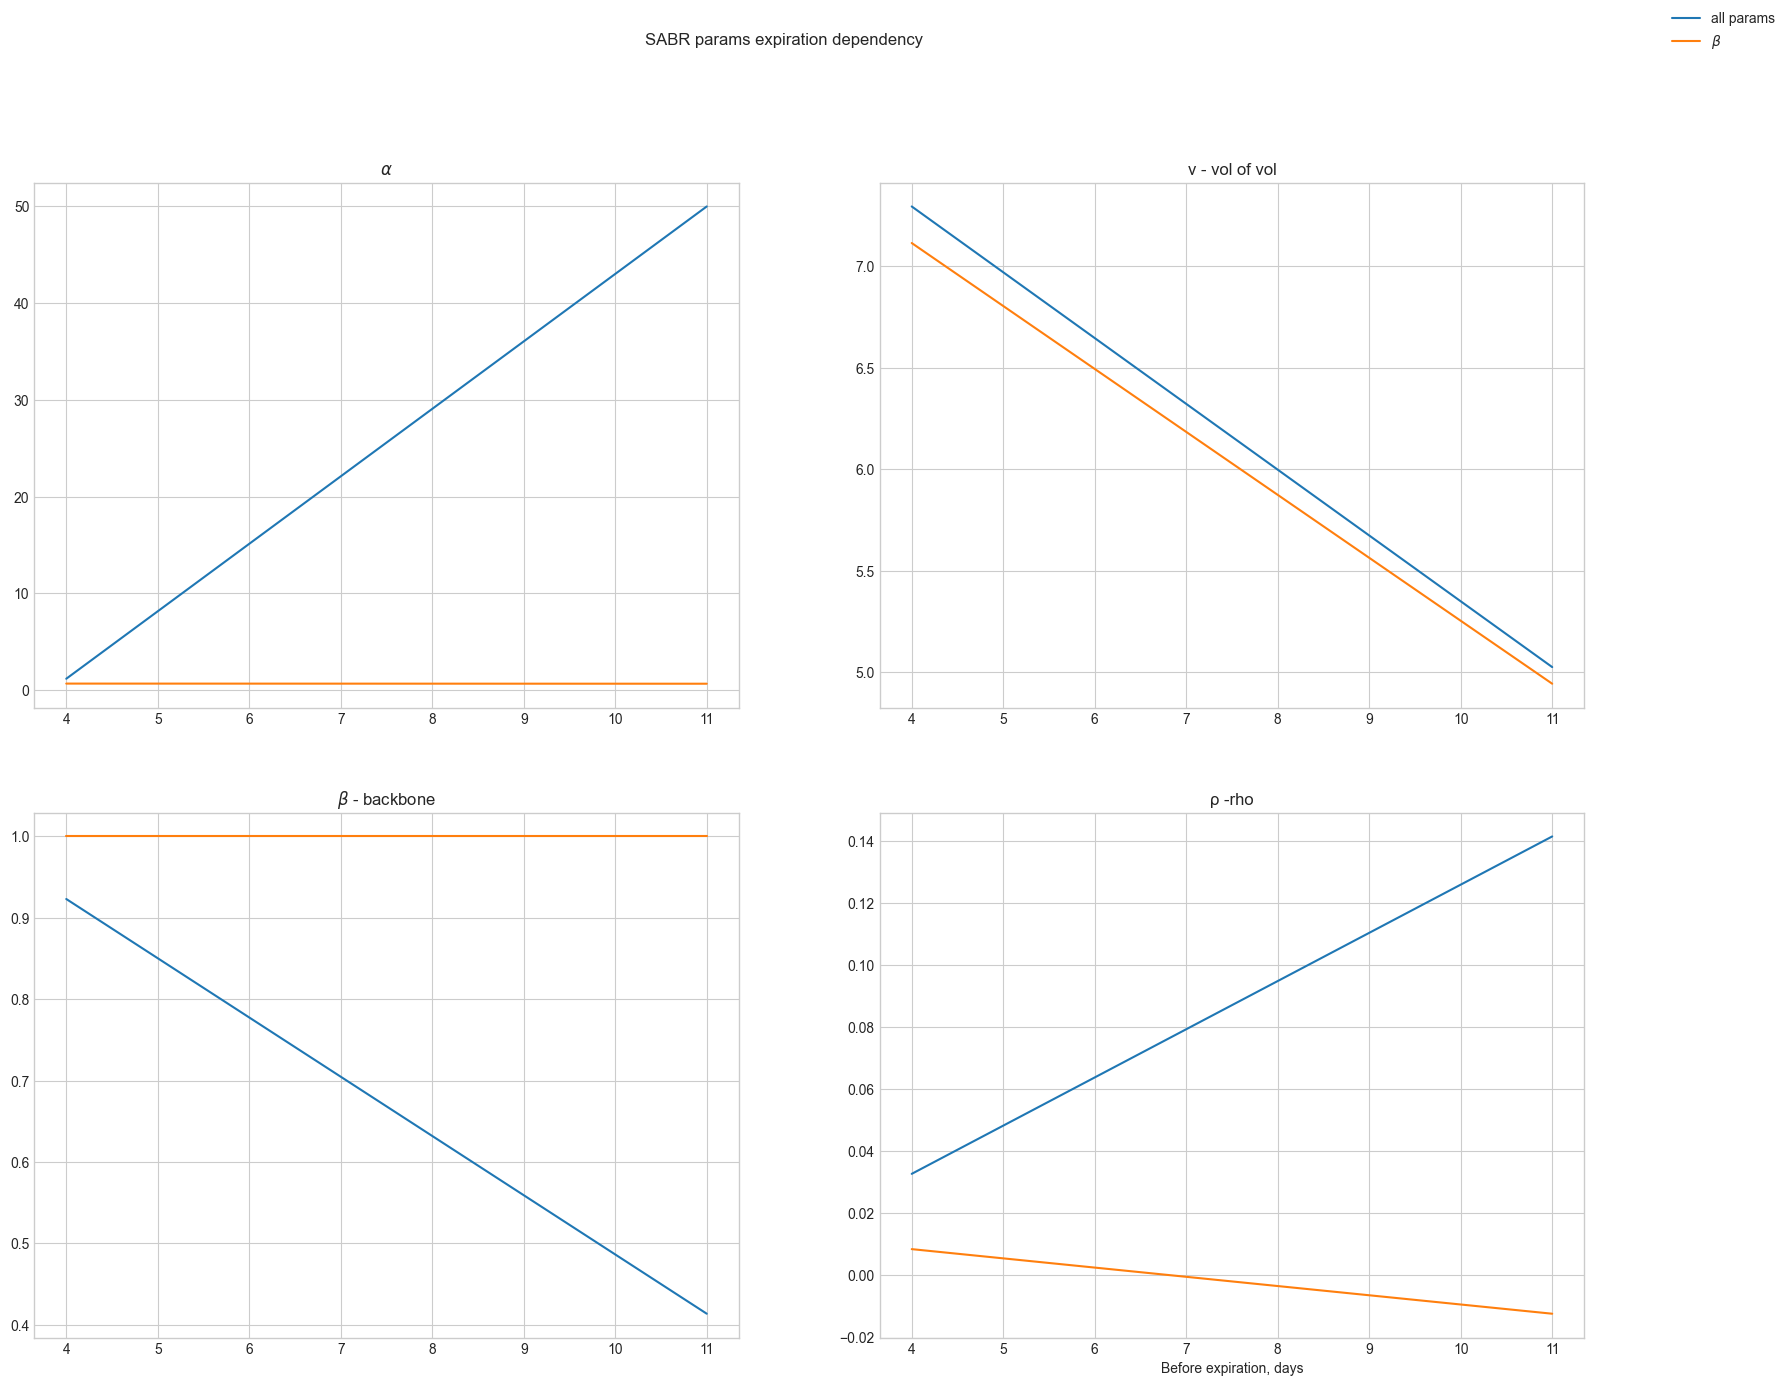

In [114]:
fig, axs =  plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

axs[0, 0].plot(expirations_list_days, params_all_exp[0], label = "all params")
axs[0, 1].plot(expirations_list_days, params_all_exp[1])
axs[1, 0].plot(expirations_list_days, params_all_exp[2])
axs[1, 1].plot(expirations_list_days, params_all_exp[3])

axs[0, 0].plot(expirations_list_days, params_beta_exp[0], label = r"$\beta$")
axs[0, 1].plot(expirations_list_days, params_beta_exp[1])
axs[1, 0].plot(expirations_list_days, params_beta_exp[2])
axs[1, 1].plot(expirations_list_days, params_beta_exp[3])

axs[0, 0].set_title(r"$\alpha$")
axs[0, 1].set_title(r"v - vol of vol")
axs[1, 0].set_title(r"$\beta$ - backbone")
axs[1, 1].set_title("ρ -rho")

plt.figlegend() 
fig.suptitle("SABR params expiration dependency")
# plt.gcf().autofmt_xdate()
plt.xlabel("Before expiration, days")
plt.show()